In [1]:
from balloon_initial import *

/home/johan/miniconda3/envs/pyoptsparse/lib/python3.9/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


In [2]:
from datastructures.api import (edges_no_param, addobj, addineq, merge, 
setsolvefor, var_params, copy_dicts, OPT)
from datastructures.graphutils import flatten_tree, all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate, invert_edges
from datastructures.transformations import transform_components
from datastructures.rendering import render_incidence
from datastructures.runpipeline import model_to_problem
from datastructures.postprocess import print_outputs
import openmdao.api as om

In [3]:
from ipywidgets import interact

### Configuration

In [4]:
global run_optimal_structure
def f(optimal_structure):
    global run_optimal_structure
    run_optimal_structure=optimal_structure
interact(f, optimal_structure=True);

interactive(children=(Checkbox(value=True, description='optimal_structure'), Output()), _dom_classes=('widget-…

### Load structure of model

In [5]:
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

### Restructure design model

We force variables from the constraints to be inputs:

In [6]:
not_input = ['T_z','p_z','g_z',r'\rho_z', r'm_{rz}', 'm_{r0}', 'h_z', 'r_z', 'V_z', 'L_z', 'W_z', 'W_0']
not_output = []#[r'm_{rz}', 'm_{r0}']

In [7]:
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-06


### Build structure of optimization model

In [8]:
outset_opt = None
if run_optimal_structure:
    outset_opt = {right:left for left, right in edges_left_right 
                  if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [9]:
tree_for_reformulation = flatten_tree(tree, 'opt')
not_outputs = var_params(model, edges)
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', solveforvars=False, mdf=True) # For OPT do not have subproblems so no need to set mdf=True/False
edges_minassign_noparam = edges_no_param(model, edges_minassign)

In [10]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [11]:
newcomps

[(('m_l',), 13, ('m_{r0}',), 'm_l'),
 (('m_v', 'm_b', 'm_p', 'm_t'), 14, ('m_l',), '-m_p - m_v - m_b + m_t'),
 (('C_D', 'D', '\\rho_0', 'A_0'), 18, ('v',), 'sqrt(2)*sqrt(D/(C_D*\\rho_0*A_0))'),
 (('r_0',), 19, ('A_0',), '9.86960440108934*r_0**2'),
 (('V_0',), 20, ('r_0',), '0.620350490899399*V_0**(1/3)'),
 (('\\rho_{LG0}', 'm_{r0}'), 22, ('V_0',), 'm_{r0}/\\rho_{LG0}')]

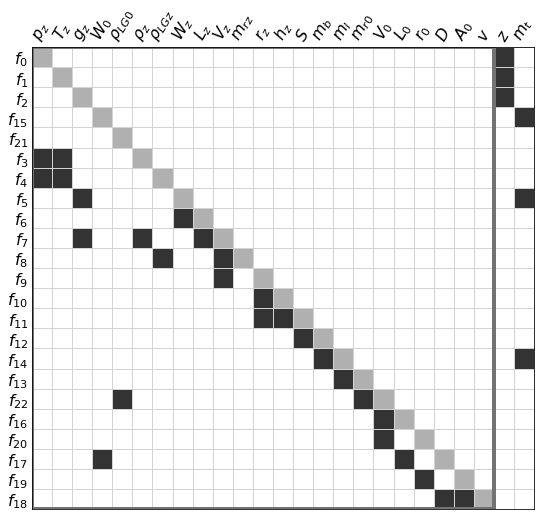

In [12]:
_, ax = render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

### Optimization formulation

In [13]:
opt = addsolver(m, name="opt", idbyname=True)
addobj(opt, m_t)
if run_optimal_structure:
    addineq(opt, 0.1-vr)

In [14]:
solvefor_init = [vr]
varoptions_init = {vr:[0.1,10]}# Pcomms:[10,100]}

In [15]:
solvefor_opt = [m_t]
varoptions_opt = {m_t:[9000]}

In [16]:
solvefor, varoptions = ((solvefor_init, varoptions_init), (solvefor_opt, varoptions_opt))[run_optimal_structure]
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT, 'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}

In [17]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)
edges_ma_opt_noparam = edges_no_param(model, edges_ma_opt)

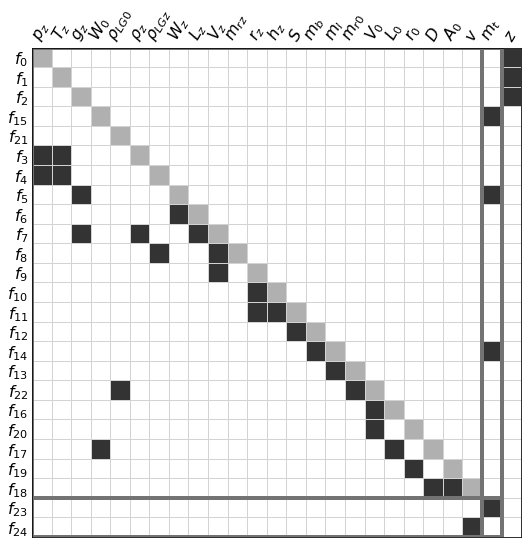

In [18]:
_, ax = render_incidence(edges_ma_opt_noparam, tree_ma_opt, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

In [24]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [25]:
prob.set_val('m_t', 10000)
prob.run_model()

In [26]:
prob.get_val('v')

array([7.5017128])

In [27]:
#print_outputs(model, prob, namingfunc, rounding=3)

In [28]:
out = prob.run_driver()



Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                    1.0257
       User Objective Time :       0.0343
       User Sensitivity Time :     0.9796
       Interface Time :            0.0021
       Opt Solver Time:            0.0097
    Calls to Objective Function :       3
    Calls to Sens Function :            3


   Objectives
      Index  Name                 Value
          0  f23.obj23     9.009990E+03

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name        Type      Lower Bound            Value      Upper Bound     Status
          0  inp.m_t_0      c     9.000000E+03     9.009990E+03     1.000000E+30           

   Constraints (i - inequality, e - equality)
      Index  Name      Type          Lower           Value           Upper    Status  Lagrange Multiplier (N/A)
          0  f24.neq2

In [32]:
prob.driver.pyopt_solution.optInform['value']

-2

In [29]:
out

True

In [27]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals']);

----------------
Design Variables
----------------
name  val              size  lower   upper  
----  ---------------  ----  ------  ----- 
m_t   [9009.98992092]  1     9000.0  1e+30  

-----------
Constraints
-----------
name   val    size  lower   upper  equals  
-----  -----  ----  ------  -----  ------ 
neq24  [0.1]  1     -1e+30  0.0    None    

----------
Objectives
----------
name   val              size  
-----  ---------------  ---- 
obj23  [9009.98992092]  1     



In [37]:
prob.run_driver()

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: [9219.]
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------


True